# Data preparation

In [239]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from missingpy import KNNImputer, MissForest
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import itertools

In [152]:
#plot settings
sns.set(context='notebook', 
        style='whitegrid', 
        palette='muted')

In [153]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [154]:
df = df_train
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [155]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [156]:
print('Minimum passenger ID in test data: ', min(df_test['PassengerId']),
      '\nMax pass ID in test data: ', max(df_test['PassengerId']),
      '\nMinimum passenger ID in test data: ', min(df_train['PassengerId']),
      '\nMax pass ID in test data: ', max(df_train['PassengerId']))

Minimum passenger ID in test data:  892 
Max pass ID in test data:  1309 
Minimum passenger ID in test data:  1 
Max pass ID in test data:  891


The plan:
* create a function with feature creation
    1. interpolate data for missing variables
    2. create a few extra variables (title, family size)
    

* apply to the test set
* do model things

## Explore the data


In [157]:
df.describe() ## R version of summary()
## quotation marks are necessary

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [158]:
# how big is the dataset?
print(df.shape[0], 'rows and ', df.shape[1], 'cols')

891 rows and  12 cols


In [159]:
# how many are NAs?
print("How many nulls are there?")

df.isnull().sum()

How many nulls are there?


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [160]:
# % of NaN from total
print("What percentage are nulls from all")
df.isnull().sum()/df.shape[0] * 100

What percentage are nulls from all


PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [161]:
df['Title'] = df.Name.str.extract(r',\s*([^\.]*)\s*\.', expand=False)
#df['Title'].value_counts()

In [162]:
print('Removing least common titles')
#combi$Title[combi$Title %in% c('Mme', 'Mlle')] <- 'Mlle'
#combi$Title[combi$Title %in% c('Capt', 'Don', 'Major', 'Sir')] <- 'Sir'
#combi$Title[combi$Title %in% c('Dona', 'Lady', 'the Countess', 'Jonkheer')] <- 'Lady'

df['Title'] = df['Title'].replace(
    to_replace = ['Capt', 'Don', 'Major', 'Sir'], value='Rare'
).replace(
    to_replace = ['Mme', 'Mlle', 'Ms'], value = 'Miss'
).replace(
    to_replace = ['Dona', 'Lady', 'the Countess', 'Jonkheer'], value = 'Rare'
).replace(
    to_replace = ['Dr', 'Rev', 'Col'], value = 'Rare'
)
df['Title'].value_counts()

Removing least common titles


Mr        517
Miss      186
Mrs       125
Master     40
Rare       23
Name: Title, dtype: int64

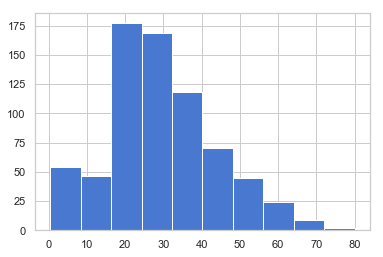

In [163]:
df['Age'].hist();
#before transformations

/Users/anastasiakuprina/anaconda3/lib/python3.7/site-packages/missingpy/utils.py:124: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


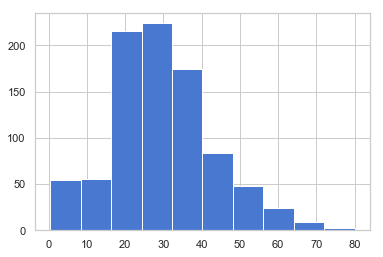

In [164]:

#df['Age'].fillna(df['Age'].mean(), inplace=True)
#very_annoying_shit = np.reshape(df['Age'].values, (-1, df.shape[0]))
#X_filled_ii = IterativeImputer().fit_transform(very_annoying_shit)
imputer = KNNImputer(n_neighbors=3, weights="uniform")
df_numeric_only = df.select_dtypes(include = [np.number])

X_imputed = imputer.fit_transform(df_numeric_only)

#pd.DataFrame(X_imputed)
df['Age_fixed'] = X_imputed[:,3]
df['Age_fixed'].hist();
#df['Age_fixed_up'] = KNN(k=3).fit_transform(df['Age'])
#df['Age_fixed_up'].hist()
# other options
# Embarked will have to do simply with a mode
#df['Embarked'].mode()
#df['Age_linear_interpolate'] = df['Age'].interpolate(method='linear',  order=2)
#df['Age_linear_interpolate'].hist();

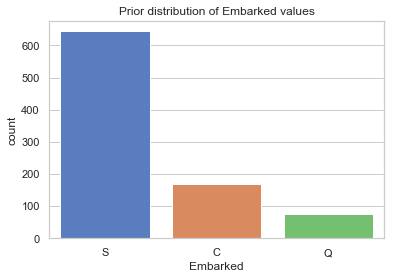

In [165]:
sns.countplot(x="Embarked", data=df).set_title("Prior distribution of Embarked values");

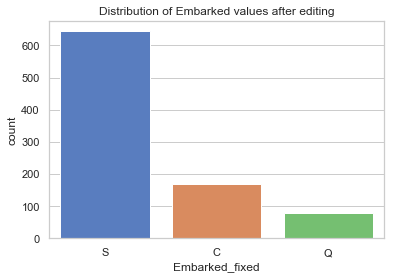

In [166]:
df['Embarked_fixed'] = df['Embarked'].interpolate(method='pad')
sns.countplot(x="Embarked_fixed", data=df).set_title(
    "Distribution of Embarked values after editing");

In [167]:
print("What percentage are nulls from all")
df.isnull().sum()/df.shape[0] * 100

#df['Embarked_mode'] = df['Embarked'].fillna(value = df['Embarked'].mode())
#sns.countplot(x="Embarked_mode", data=df).set_title(
#    "Distribution of Embarked values with mode");
#df['Embarked_mode'].isnull().sum()

What percentage are nulls from all


PassengerId        0.000000
Survived           0.000000
Pclass             0.000000
Name               0.000000
Sex                0.000000
Age               19.865320
SibSp              0.000000
Parch              0.000000
Ticket             0.000000
Fare               0.000000
Cabin             77.104377
Embarked           0.224467
Title              0.000000
Age_fixed          0.000000
Embarked_fixed     0.000000
dtype: float64

## Visualisations

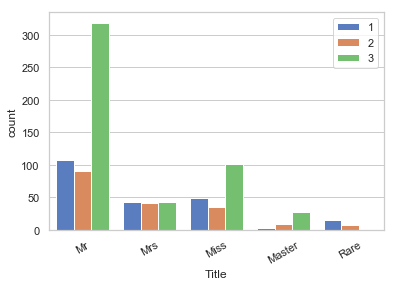

In [168]:
p = sns.countplot(x="Title", data=df,
             hue="Pclass")
p.set_xticklabels(p.get_xticklabels(),rotation=30)
plt.legend(loc='upper right');

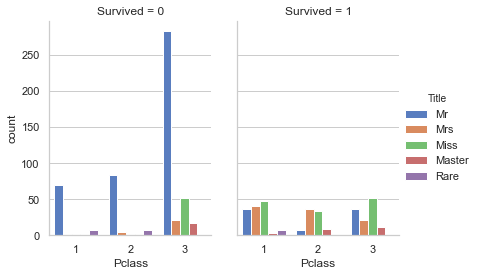

In [169]:
sns.catplot(x="Pclass", hue="Title", col="Survived",
                 data=df, kind="count",
                 height=4, aspect=.7);

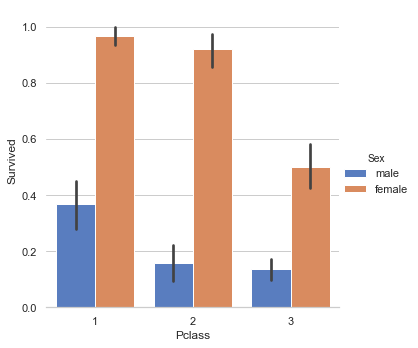

In [170]:
g = sns.catplot("Pclass", "Survived", "Sex",
                   data=df, kind="bar")
g.despine(left=True);

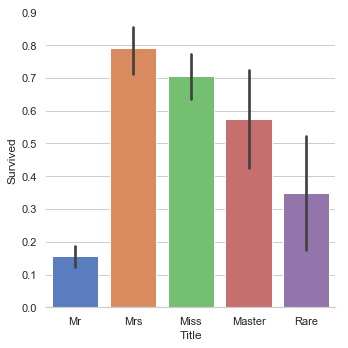

In [171]:
g = sns.catplot("Title", "Survived",
                   data=df, kind="bar")
g.despine(left=True);

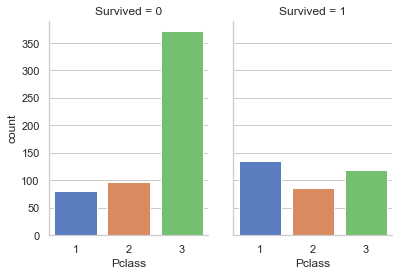

In [172]:
sns.catplot(x="Pclass", col="Survived",
                 data=df, kind="count",
                 height=4, aspect=.7);

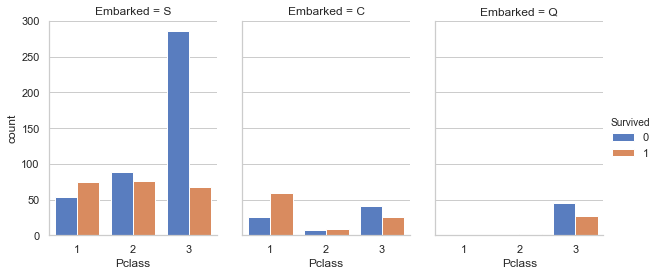

In [173]:
sns.catplot(x="Pclass", col="Embarked", hue = 'Survived',
                 data=df, kind="count",
                 height=4, aspect=.7);

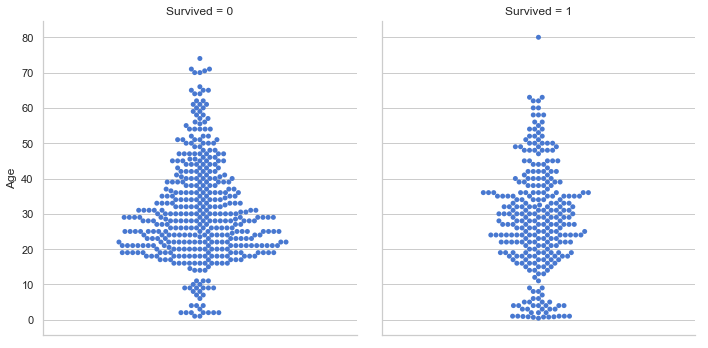

In [174]:
sns.catplot(y="Age", col = 'Survived', 
                 data=df, kind="swarm");

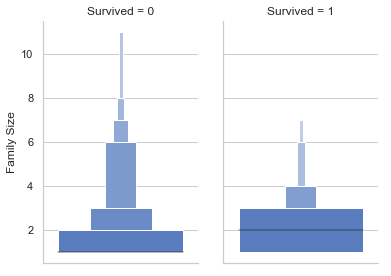

In [175]:
df['Family Size'] = df['SibSp'] + df['Parch'] + 1
sns.catplot(y="Family Size", col="Survived",
                 data=df, kind="boxen",
                 height=4, aspect=.7);

## Variable encoding

In [176]:
#df %>% mutate(ifelse(sex = female, 1, 0))
# dummify gender
df['Sex_isfemale'] = df['Sex'].apply(lambda x: 1 if x == 'female' else 0)
df[['Sex', 'Sex_isfemale']].head()

,Sex,Sex_isfemale
0,male,0
1,female,1
2,female,1
3,female,1
4,male,0


In [177]:
# dummify Embarked
df = pd.get_dummies(df, columns = ["Embarked"], prefix="Embark")

In [178]:
# dummify Title
df = pd.get_dummies(df, columns = ["Title"], prefix = 'Title')

In [179]:
df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Age_fixed', 'Embarked_fixed',
       'Family Size', 'Sex_isfemale', 'Embark_C', 'Embark_Q', 'Embark_S',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Rare'], dtype=object)

# Modeling

In [195]:
# features to choose from
#df.head()
feature_cols = ['Pclass','SibSp',
           'Parch', 'Fare', 'Age_fixed',
           'Family Size', 'Sex_isfemale', 'Embark_C', 'Embark_Q', 'Embark_S',
           'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
           'Title_Rare']

In [191]:
def make_it_all_okay(data):
    # create Title feature based on the name
    data['Title'] = data.Name.str.extract(r',\s*([^\.]*)\s*\.', expand=False)
    
    # make Title more readable
    data['Title'] = data['Title'].replace(
    to_replace = ['Capt', 'Don', 'Major', 'Sir'], value='Rare'
    ).replace(
        to_replace = ['Mme', 'Mlle', 'Ms'], value = 'Miss'
    ).replace(
        to_replace = ['Dona', 'Lady', 'the Countess', 'Jonkheer'], value = 'Rare'
    ).replace(
        to_replace = ['Dr', 'Rev', 'Col'], value = 'Rare'
    )
    
    # create family size feature
    data['Family Size'] = data['SibSp'] + data['Parch'] + 1
    
    # use KNN to interpolate age
    imputer = KNNImputer(n_neighbors=3, weights="uniform")
    data_numeric_only = data.select_dtypes(include = [np.number])
    X_imputed = imputer.fit_transform(data_numeric_only)
    data['Age_fixed'] = X_imputed[:,3]
    
    # fix Embarked using pd methods
    data['Embarked_fixed'] = data['Embarked'].interpolate(method='pad')
    
    # DUMMIFYING
    # dummify gender data
    data['Sex_isfemale'] = data['Sex'].apply(lambda x: 1 if x == 'female' else 0)

    # dummify embarked data
    data = pd.get_dummies(data, columns = ["Embarked"], prefix="Embark")
    
    # dummify title data
    data = pd.get_dummies(data, columns = ["Title"], prefix = 'Title')
    
    # make sure df only has those
    out = data[feature_cols]
    
    return out
X_train = make_it_all_okay(data = df_train)
y_train = df_train['Survived']

X_test = make_it_all_okay(data = df_test)
y_test = []

/Users/anastasiakuprina/anaconda3/lib/python3.7/site-packages/missingpy/utils.py:124: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [182]:
X_train_faked, X_test_faked, y_train_faked, y_test_faked = train_test_split(X_train, y_train, test_size=0.3, random_state=1) 

In [245]:
def decision_tree(**args):
    clf = DecisionTreeClassifier(**args)
    # Train Decision Tree Classifer
    clf = clf.fit(X_train_faked,y_train_faked)
    y_pred = clf.predict(X_test_faked)
    # print accuracy
    #print(args, "\nAccuracy:", metrics.accuracy_score(y_test_faked, y_pred), "\n")
    #print("Variable importance: ", dict(zip(feature_cols, clf.feature_importances_)))
    
    return {
        "accuracy" : metrics.accuracy_score(y_test_faked, y_pred),
        "varimp" : dict(zip(feature_cols, clf.feature_importances_)),
        "clf" : clf
    }

entropy_rand_decision_tree = decision_tree(criterion='entropy', splitter = 'random')
entropy_best_decision_tree = decision_tree(criterion='entropy', splitter = 'best')
entropy_best_decision_tree_3 = decision_tree(criterion='entropy', splitter = 'best', max_depth = 3)
entropy_best_decision_tree_5 = decision_tree(criterion='entropy', splitter = 'best', max_depth = 5)
entropy_best_decision_tree_7 = decision_tree(criterion='entropy', splitter = 'best', max_depth = 7)

gini_best_decision_tree = decision_tree(criterion='gini', splitter = 'best')
gini_rand_decision_tree = decision_tree(criterion='gini', splitter = 'random')
gini_best_decision_tree_3 = decision_tree(criterion='gini', splitter = 'best', max_depth = 3)
gini_best_decision_tree_5 = decision_tree(criterion='gini', splitter = 'best', max_depth = 5)
gini_best_decision_tree_7 = decision_tree(criterion='gini', splitter = 'best', max_depth = 7)

In [248]:
all_models = []

for criterion, splitter, max_depth in itertools.product(
    ["gini", "entropy"],
    ["best", "random"],
    range(2,11)):
    temp_variable = decision_tree(criterion=criterion, splitter=splitter, max_depth=max_depth)
    
    all_models.append({
        "criterion": criterion,
        "splitter": splitter,
        "max_depth": max_depth,
        "accuracy": temp_variable['accuracy'],
        "clf": temp_variable['clf']
    })

all_models = pd.DataFrame.from_dict(all_models)
all_models.sort_values('accuracy', ascending = False)

,accuracy,clf,criterion,max_depth,splitter
3,0.805970,"DecisionTreeClassifier(class_weight=None, crit...",gini,5,best
2,0.798507,"DecisionTreeClassifier(class_weight=None, crit...",gini,4,best
29,0.798507,"DecisionTreeClassifier(class_weight=None, crit...",entropy,4,random
11,0.798507,"DecisionTreeClassifier(class_weight=None, crit...",gini,4,random
20,0.794776,"DecisionTreeClassifier(class_weight=None, crit...",entropy,4,best
19,0.794776,"DecisionTreeClassifier(class_weight=None, crit...",entropy,3,best
22,0.791045,"DecisionTreeClassifier(class_weight=None, crit...",entropy,6,best
1,0.791045,"DecisionTreeClassifier(class_weight=None, crit...",gini,3,best
4,0.787313,"DecisionTreeClassifier(class_weight=None, crit...",gini,6,best
16,0.783582,"DecisionTreeClassifier(class_weight=None, crit...",gini,9,random


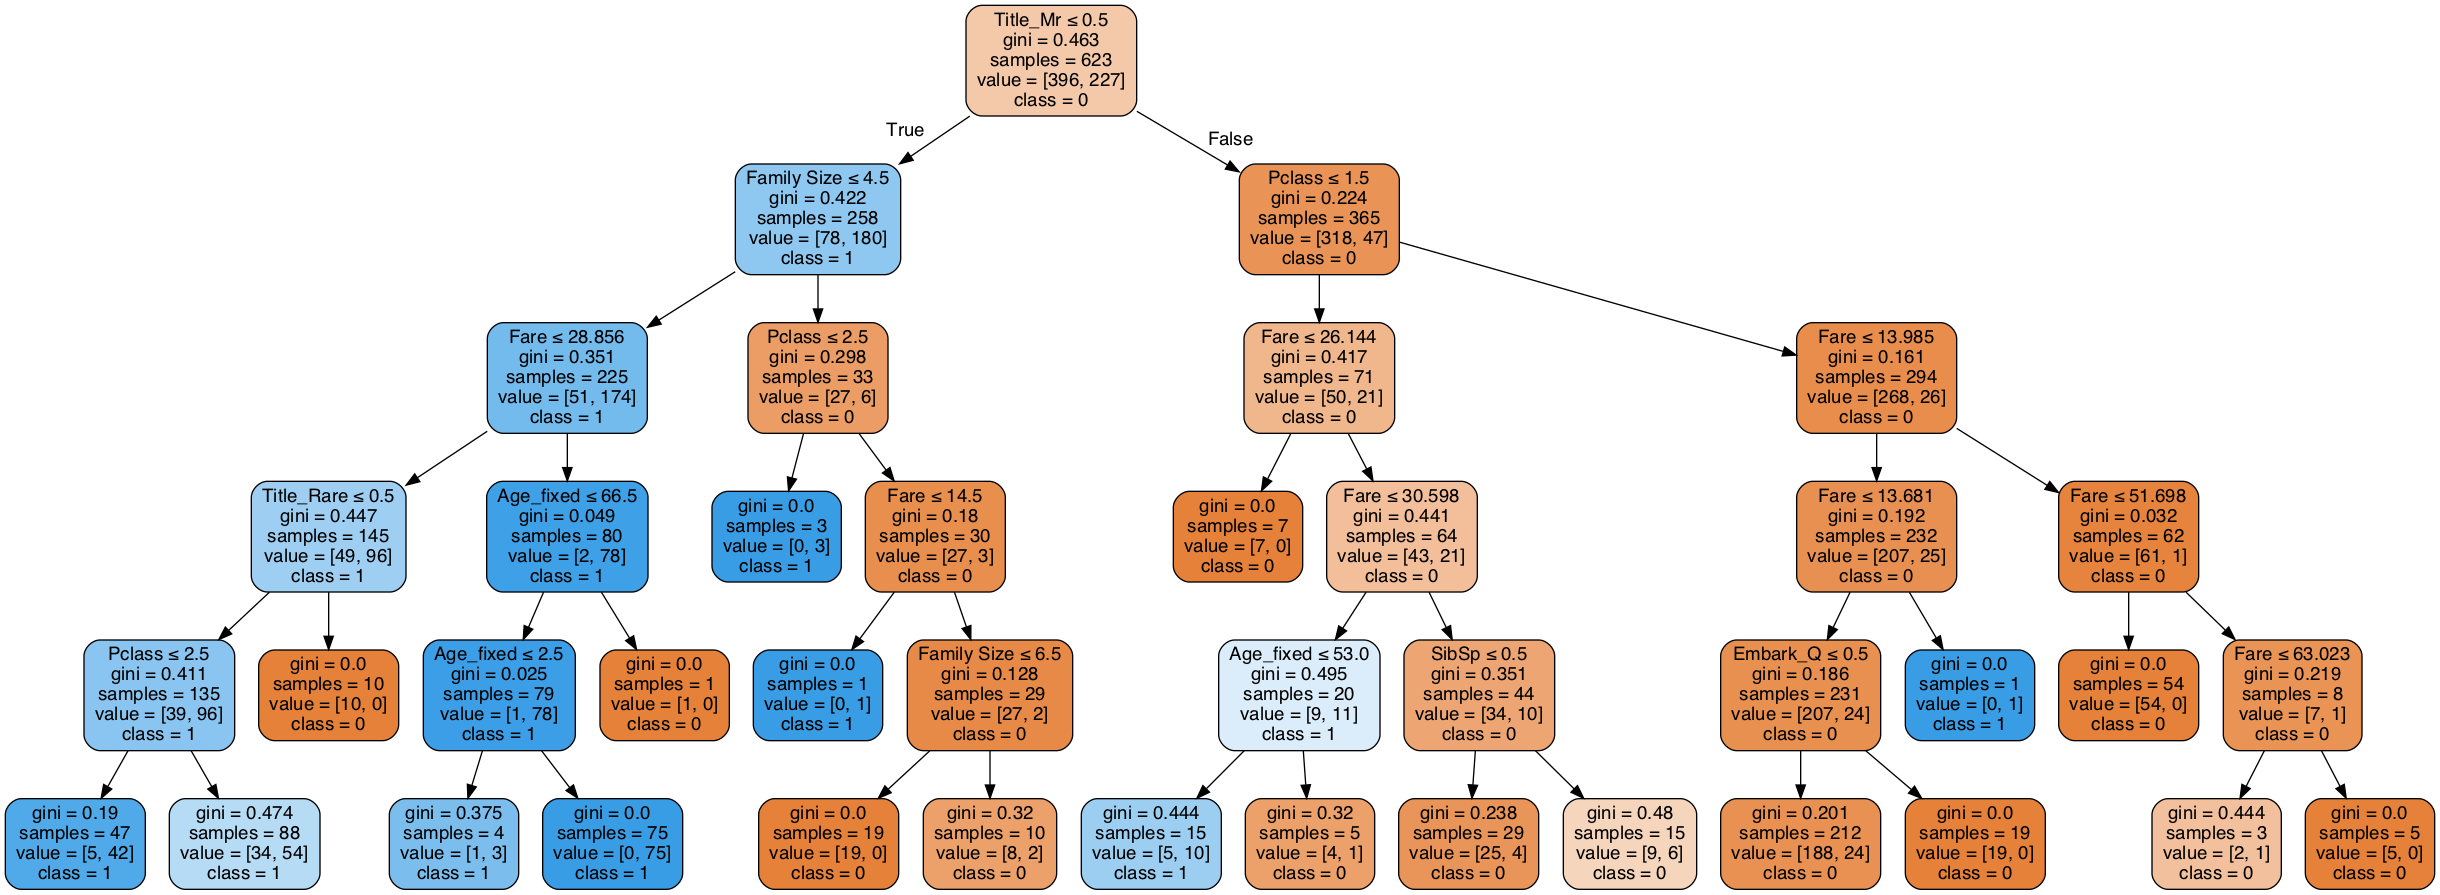

In [242]:
dot_data = StringIO()
export_graphviz(gini_best_decision_tree_5['clf'], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('titanic_gini.png')
Image(graph.create_png())

# command + slash